From `analysis_notebooks/R68_meas_spectra_plot.ipynb`

In [1]:
#Import libraries and settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
exec(open("../analysis_notebooks/nb_setup.py").read())
from constants import *
import R68_load as r68
import R68_efficiencies as eff
meas=r68.load_measured()
import R68_spec_tools as spec

from matplotlib import *
style.use('../mplstyles/stylelib/standard.mplstyle')

fig_w=7 #Used later for figure width

../mplstyles
3.4.2
/mnt/d/git/R68_paper2019/mplstyles
Loading Measured Data...
PuBe events:  (476731,)
Bkg events:  (174636,)


In [2]:
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2
Efit_min=50#[eVee]
Efit_max=1750#[eVee]
spec_bounds=(np.digitize(Efit_min,Ebins)-1,np.digitize(Efit_max,Ebins)-1)

Ebins_ctr[slice(*spec_bounds)].shape

(170,)

In [3]:
#Measured
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)
#Count uncertainties are Poisson
dN_meas_PuBe_Pois=np.sqrt(N_meas_PuBe)
dN_meas_Bkg_Pois=np.sqrt(N_meas_Bkg)

#Include uncertainty from efficiencies
dN_meas_PuBe = N_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 + (eff.deff_write/eff.eff_write)**2 +
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2)
dN_meas_Bkg = N_meas_Bkg*np.sqrt( (dN_meas_Bkg_Pois/N_meas_Bkg)**2 + (eff.deff_write_bkg/eff.eff_write_bkg)**2 +
                                   (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
#Scaling factors
tlive_ratio=meas['PuBe']['tlive']/meas['Bkg']['tlive']
writeEff_ratio=eff.eff_write/eff.eff_write_bkg
dwriteEff_ratio=writeEff_ratio*np.sqrt( (eff.deff_write/eff.eff_write)**2 + (eff.deff_write_bkg/eff.eff_write_bkg)**2 )

cutEff_ratio=eff.cutEffFit(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr)
dcutEff_ratio = cutEff_ratio*np.sqrt( (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 + 
                                     (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 )

ratio=tlive_ratio*writeEff_ratio*cutEff_ratio
dratio=ratio*np.sqrt( (dwriteEff_ratio/writeEff_ratio)**2 +(dcutEff_ratio/cutEff_ratio)**2 )

#Make sure any divide by 0s happened below threshold
if (not np.all(np.isfinite(ratio[slice(*spec_bounds)]))) or (not np.all(np.isfinite(dratio[slice(*spec_bounds)]))):
    print('Error: Bad background scaling ratio in fit range.')

#Bkg-subtracted measured PuBe signal
N_bkg_scaled=N_meas_Bkg*ratio
dN_bkg_scaled=N_bkg_scaled*np.sqrt( (dN_meas_Bkg/N_meas_Bkg)**2 + (dratio/ratio)**2 )

N_meas = N_meas_PuBe - N_bkg_scaled
dN_meas = np.sqrt( dN_meas_PuBe**2 + dN_bkg_scaled**2 ) #All errors are symmetric here when using the conservative cut eff fits
dN_meas_stat = np.sqrt( dN_meas_PuBe_Pois**2 + (dN_meas_Bkg_Pois*ratio)**2 )

<ipython-input-3-7583d77f5557>:12: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
<ipython-input-3-7583d77f5557>:18: RuntimeWarning: divide by zero encountered in true_divide
  cutEff_ratio=eff.cutEffFit(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr)
<ipython-input-3-7583d77f5557>:20: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 )
<ipython-input-3-7583d77f5557>:23: RuntimeWarning: invalid value encountered in true_divide
  dratio=ratio*np.sqrt( (dwriteEff_ratio/writeEff_ratio)**2 +(dcutEff_ratio/cutEff_ratio)**2 )


In [4]:
Denom_PuBe = meas['PuBe']['tlive']*eff.eff_write*eff.cutEffFit(Ebins_ctr)*eff.trigEff(Ebins_ctr)
R_meas_PuBe = N_meas_PuBe/Denom_PuBe
Denom_Bkg = meas['Bkg']['tlive']*eff.eff_write_bkg*eff.cutEffFit_bkg(Ebins_ctr)*eff.trigEff(Ebins_ctr)
R_meas_Bkg = N_meas_Bkg/Denom_Bkg

R_meas = R_meas_PuBe - R_meas_Bkg

dR_meas_stat_PuBe = R_meas_PuBe*dN_meas_PuBe_Pois/N_meas_PuBe
dR_meas_PuBe = R_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 +\
                                   (eff.deff_write/eff.eff_write)**2 +\
                                   (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 +\
                                   (eff.dtrigEff(Ebins_ctr)/eff.trigEff(Ebins_ctr))**2 )
dR_meas_stat_Bkg = R_meas_Bkg*dN_meas_Bkg_Pois/N_meas_Bkg
dR_meas_Bkg = R_meas_Bkg*np.sqrt( (dN_meas_Bkg_Pois/N_meas_Bkg)**2 +\
                                 (eff.deff_write_bkg/eff.eff_write_bkg)**2 +\
                                 (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
                                 (eff.dtrigEff(Ebins_ctr)/eff.trigEff(Ebins_ctr))**2 )

dR_meas_stat = np.sqrt(dR_meas_stat_PuBe**2 + dR_meas_stat_Bkg**2)
dR_meas = np.sqrt(dR_meas_PuBe**2 + dR_meas_Bkg**2)

<ipython-input-4-fae1f8eaa098>:4: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/Denom_Bkg
<ipython-input-4-fae1f8eaa098>:16: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\


In [5]:
c_stat,dc_stat=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=False, doBurstLeaksyst=False, output='counts')
c_syst,dc_syst=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=False, output='counts')
c_syst2,dc_syst2=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=True, output='counts')

r_stat,dr_stat=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=False, doBurstLeaksyst=False, output='reco-rate')
r_syst,dr_syst=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=False, output='reco-rate')
r_syst2,dr_syst2=spec.doBkgSub(r68.load_measured(verbose=False), Ebins, Efit_min, Efit_max, doEffsyst=True, doBurstLeaksyst=True, output='reco-rate')

../python/R68_spec_tools.py:55: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:80: RuntimeWarning: divide by zero encountered in true_divide
  N_bkg_scaled=N_meas_Bkg*TE_PuBe/TE_Bkg
../python/R68_spec_tools.py:96: RuntimeWarning: divide by zero encountered in true_divide
  doEffsyst*(eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
../python/R68_spec_tools.py:96: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
../python/R68_spec_tools.py:100: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(dTE_Bkg/TE_Bkg)**2 )
../python/R68_spec_tools.py:60: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/TE_Bkg
../python/R68_spec_tools.py:69: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(dTE_Bkg/TE_Bkg)**2 )


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


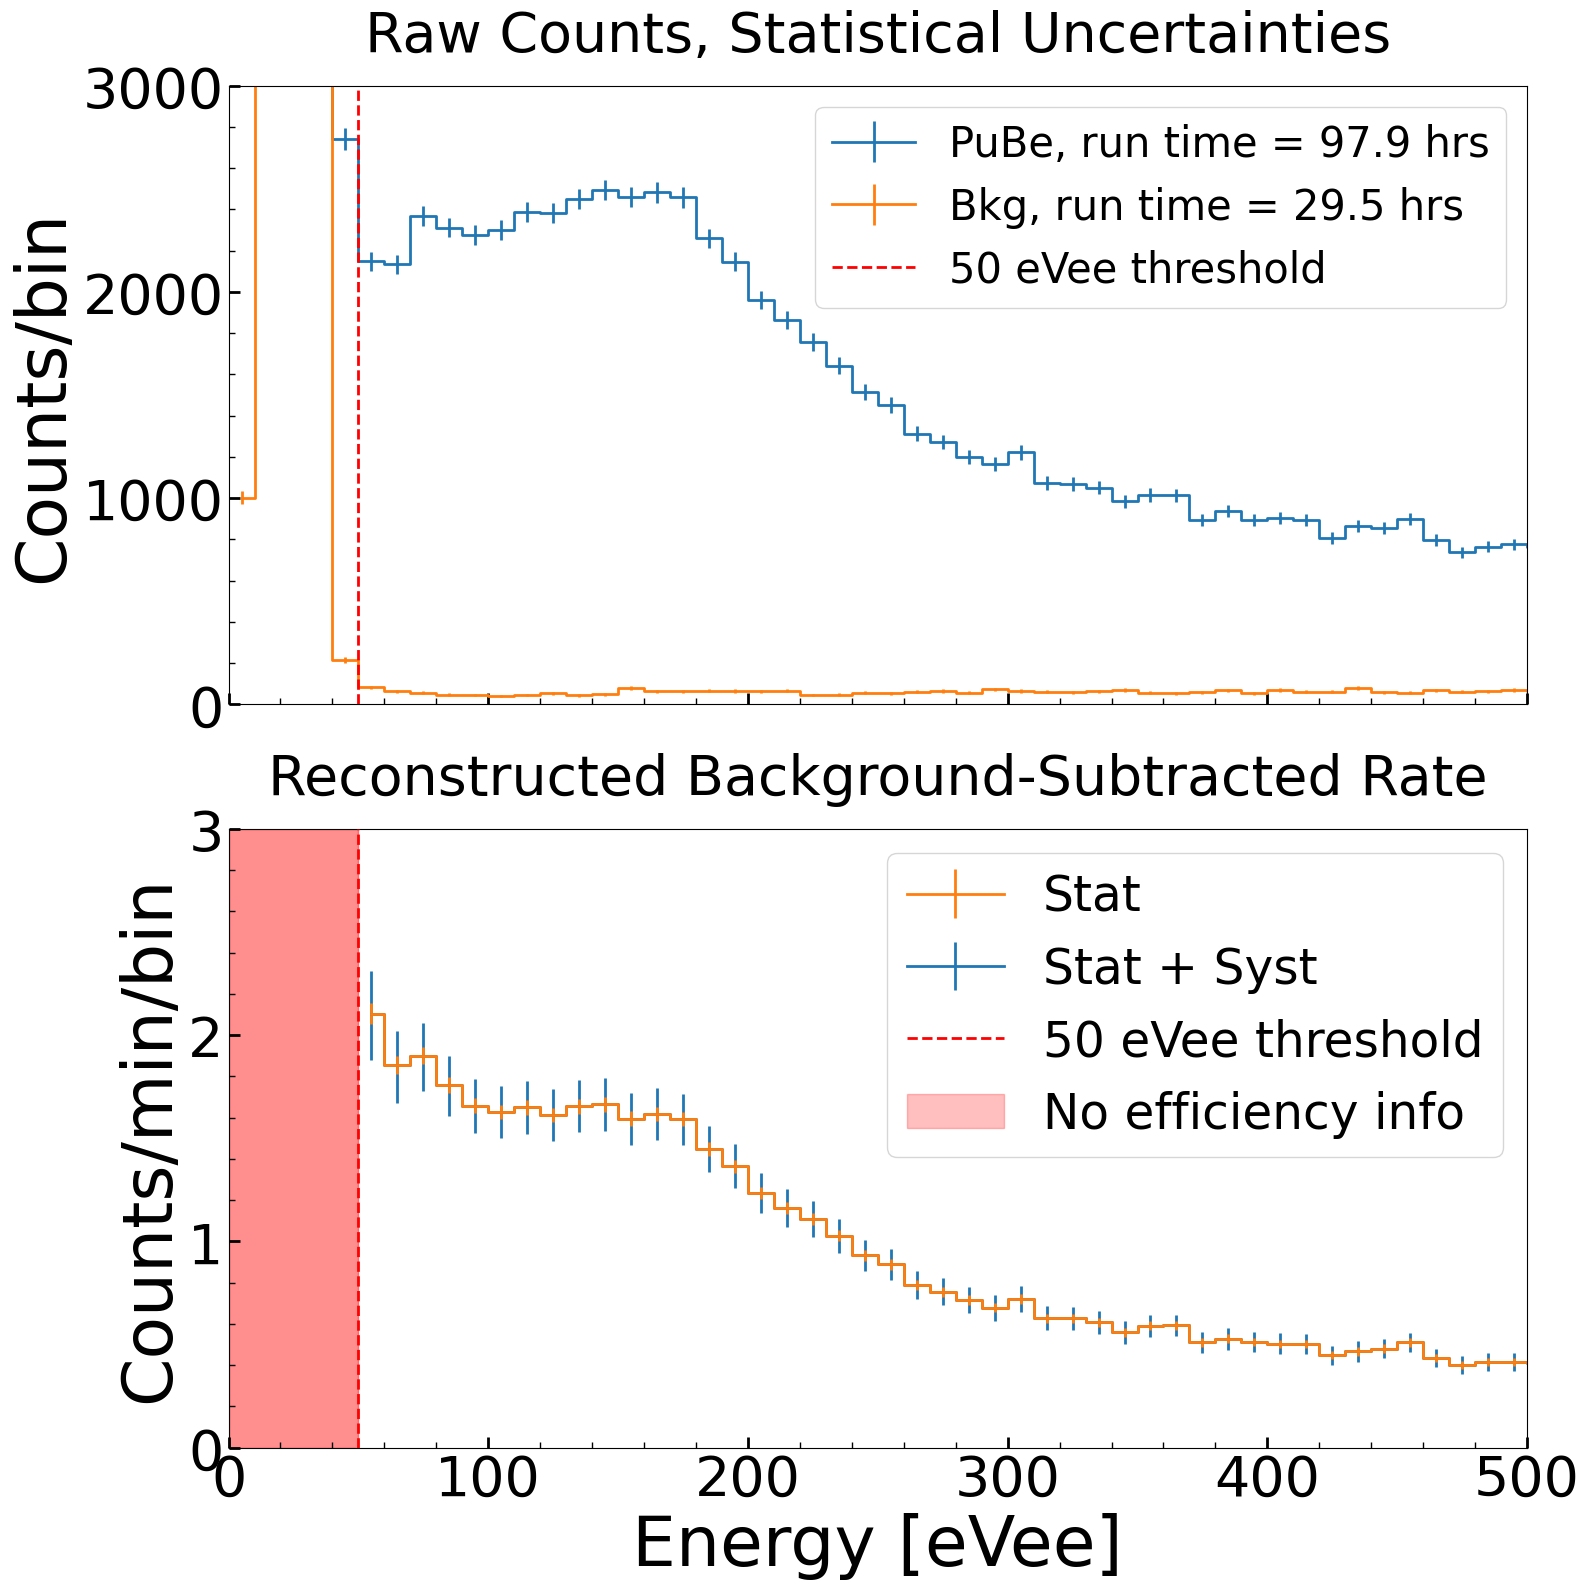

In [6]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(16,16))
fill_noise=ax[1].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)

cthresh=Ebins_ctr>=50 #Only plot hists above threshold

#Raw Count histograms
ax[0].set_title('Raw Counts, Statistical Uncertainties',size='40',pad='25')

line_c_PuBe=ax[0].errorbar(Ebins_ctr,N_meas_PuBe,yerr=dN_meas_PuBe_Pois, drawstyle = 'steps-mid', linewidth=2)
line_c_Bkg=ax[0].errorbar(Ebins_ctr,N_meas_Bkg,yerr=dN_meas_Bkg_Pois, drawstyle = 'steps-mid', linewidth=2)
line_thresh=ax[0].axvline(50,linestyle='--',color='r', label='50 eVee threshold',zorder=5)

ax[0].set_xlim(0,5e2)
#ax[0].set_yscale('log')
ax[0].set_ylim(0,3e3)
ax[0].set_ylabel('Counts/bin')


ax[0].legend([line_c_PuBe, line_c_Bkg, line_thresh, fill_noise],
             [f"PuBe, run time = {meas['PuBe']['tlive']/3600:.1f} hrs",
              f"Bkg, run time = {meas['Bkg']['tlive']/3600:.1f} hrs",
              '50 eVee threshold'],fontsize=30)
                                       
#Reconstructed rate
                                       
#Reverse errorbar order to be [lower,upper]
ax[1].set_title('Reconstructed Background-Subtracted Rate',size='40',pad='25')
line_r_syst=ax[1].errorbar(Ebins_ctr[cthresh],60*r_syst2[cthresh],yerr=(60*dr_syst2[::-1])[:,cthresh],drawstyle = 'steps-mid', linewidth=2, label='Stat + Syst')
line_r_stat=ax[1].errorbar(Ebins_ctr[cthresh],60*r_stat[cthresh],yerr=60*dr_stat[::-1][:,cthresh],drawstyle = 'steps-mid', linewidth=2, label='Stat')
                                       
line_thresh=ax[1].axvline(50,linestyle='--',color='r', label='50 eVee threshold',zorder=5)
fill_noise=ax[1].axvspan(0,50,color='r', alpha=0.25, label='No efficiency data',zorder=0)
                                       
ax[1].legend([line_r_stat, line_r_syst, line_thresh, fill_noise],
             ['Stat', 'Stat + Syst', '50 eVee threshold', 'No efficiency info'])
    
ax[1].set_ylim(0,3)
ax[1].set_xlim(0,500)
ax[1].set_ylabel('Counts/min/bin')
ax[1].set_xlabel('Energy [eVee]')


plt.tight_layout()
plt.show()

plt.savefig('../figures/meas_spec_reco_rate_pretty.pdf')